# My Final Project
For my final project I did two things:
 1. I trained a classifier on the "distracted driver" dataset using a ResNet like network
 2. I searched for adversarial noise such that the classifier classifies images as "save driving", regardless of their true label

In [1]:
from pylibdl.data import DataLoader
from pylibdl.optim import Adam
from pylibdl.modules import Module, Sequential, Conv2d, BatchNorm2d, MaxPool2d, LeakyReLU, Linear
from pylibdl import cross_entropy_with_logits, mean, zeros, tensor, reshape
from utils import DistractedDriver, validate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import time

In [2]:
# train and val data
path = 'distracted_driver'  # path to dataset
train_data = DistractedDriver(path, val=False)
val_data = DistractedDriver(path, val=True)

## Let's look at the data

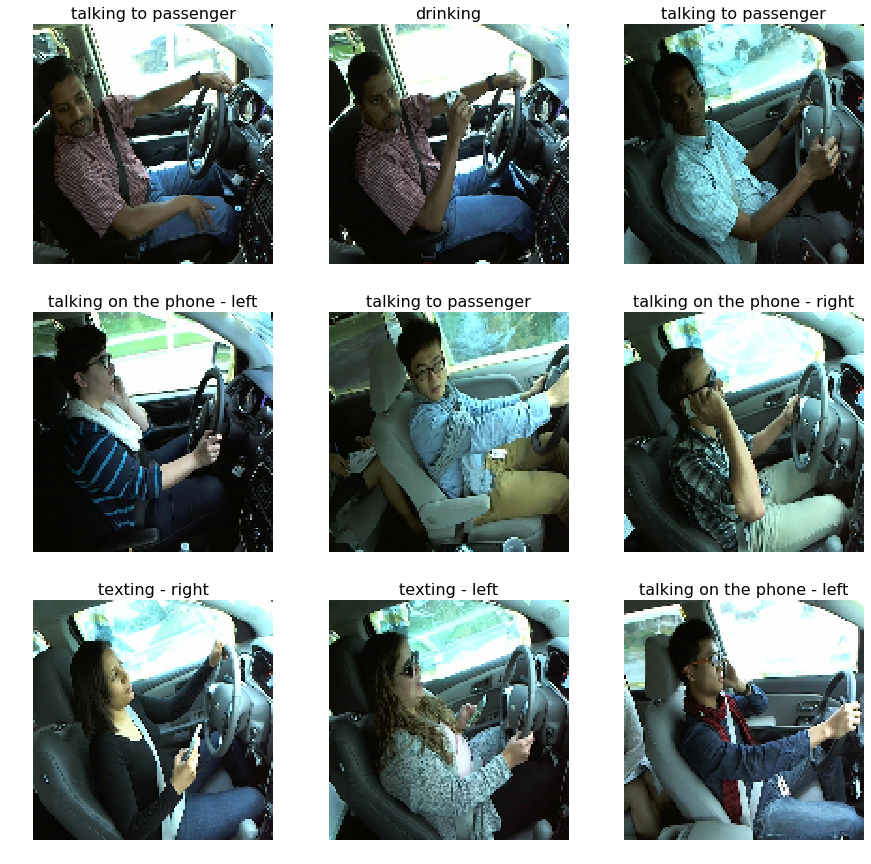

In [3]:
plot_n_rows = 3
gs = gridspec.GridSpec(plot_n_rows, 3)
plt.figure(figsize=(15, 5 * plot_n_rows)) 
for p in range(plot_n_rows * 3):
    i = random.randint(0, len(train_data))
    plt.subplot(gs[p])
    plt.axis('off')
    plt.title(DistractedDriver.label_names[train_data[i][1].argmax()], fontsize=16)
    img = DistractedDriver.denormalize(train_data[i][0]).transpose((1, 2, 0))
    plt.imshow(img)

# Network Architecture
 - I created my own network architecture inspired by ResNet
   - Two residual blocks
   - Leaky ReLU as activation function
   - Batch norm after every convolution
   - The residual connections give a performance boost of almost 20% afer 100 iterations
   - No activation function after the addition gives a performance boost of 5% after 100 iterations
   - No average pool at the end, since the position of features is quite relevant for this dataset

<img src="architecture.png" alt="drawing" width="400"/>

In [4]:
# my resnet model as depicted above
class MyResNet(Module):
    def __init__(self):
        super().__init__()
        
        self.initial = Sequential(
            Conv2d(3, 32, 5, stride=2, bias=False),  # 64x64
            BatchNorm2d(32),
            MaxPool2d(2),  # 32x32
            LeakyReLU()
        )

        self.res1 = Sequential(
            Conv2d(32, 64, 3, stride=1, bias=False),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 64, 3, stride=2, bias=False),  # 16x16
            BatchNorm2d(64)
        )
        self.adapt1 = Sequential(
            Conv2d(32, 64, 1, stride=2, bias=False),
            BatchNorm2d(64)
        )

        self.res2 = Sequential(
            Conv2d(64, 128, 3, stride=1, bias=False),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 128, 3, stride=1, bias=False),
            BatchNorm2d(128)
        )
        self.adapt2 = Sequential(
            Conv2d(64, 128, 1, stride=1, bias=False),
            BatchNorm2d(128)
        )

        self.fc = Linear(16*16*128, 10)

    def forward(self, x):
        x = self.initial(x)
        x = self.res1(x) + self.adapt1(x)
        x = self.res2(x) + self.adapt2(x)
        x = reshape(x, (16*16*128, -1))
        return self.fc(x)

# 1. Training
 - the model above is trained for 100 iterations
 - batch size of 64
 - learning rate of $10^{-4}$
 - Adam optimizer is used

In [5]:
batch_size = 64
lr = 1e-4
log_every = 10

In [6]:
# DataLoader represents an iterator over minibatches
train_loader = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)
model = MyResNet()
optim = Adam(model.parameter(), lr)

In [7]:
begin = time.time()
losses = []

# Train 100 iterations
print('iteration | loss')
for i, (imgs, labels) in enumerate(train_loader):
    
    pred = model(imgs)
    loss = cross_entropy_with_logits(pred, labels)
    loss.backward()
    optim.step()
    optim.zero_grad()
    
    losses.append(loss.data[0])
    if i % log_every == 0:
        print(f'{i: <9} | {loss.data[0]:.4f}')
    if i >= 100:
        break

# save the model
model.save('model')
print(f'\nvalidation accuracy: {validate(model, val_data)*100:.2f}%')
print(f'training took {time.time() - begin: .2f} seconds')

iteration | loss
0         | 3.0808
10        | 1.8314
20        | 1.4554
30        | 0.6504
40        | 0.5138
50        | 0.4558
60        | 0.2457
70        | 0.1971
80        | 0.2706
90        | 0.3385
100       | 0.2841

validation accuracy: 95.00%
training took  222.09 seconds


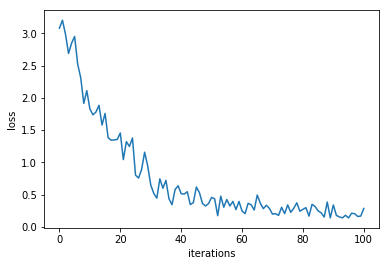

In [8]:
# plot the loss
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

# 2. Adversarial Noise
We want to classify every image as "save driving". Therefore we'll try to find some adversarial noise by minimizing the following formula with respect to the noise tensor:
$$arg\  min_{\epsilon} \ \mathcal L(m(x + \epsilon),\ y') + ||\epsilon||^2$$
 - $\mathcal L$ is the loss function (e.g. cross entropy)
 - $m$ is the model
 - $x$ is the image
 - $\epsilon$ is the adversarial noise
 - $y'$ is the fake label

In [9]:
model = MyResNet.load('model')

# set the model in eval mode so the running mean and running std of batch norm are used
model.eval()
# since we are only interested in the gradient of the noise tensor
for p in model.parameter():
    p.requires_grad = False

In [10]:
# load one image of every class 
imgs = [val_data[i*128 + random.randint(0, 128)][0] for i in range(10)]
imgs_tensor = tensor(np.stack(imgs, axis=-1))

In [11]:
# noise tensor and fake labels
eps = zeros(imgs_tensor.shape, True)
fake_labels = tensor(np.eye(10)[[0] * imgs_tensor.shape[-1]].transpose())

# find noise vector
print('iteration |  loss   | class predictions')
for i in range(5):
    pred = model(imgs_tensor + eps)
    loss = cross_entropy_with_logits(pred, fake_labels) + mean(eps**2)
    loss.backward()
    eps.sub_grad(5)  # subtract the gradient of eps from eps
    eps.zero_grad()
    
    print(f'{i: <9} | {loss.data[0]: .4f} | {np.argmax(pred.data, axis=0)}')

iteration |  loss   | class predictions
0         |  5.8319 | [0 2 2 3 4 5 6 7 8 9]
1         |  0.0069 | [0 0 0 0 0 0 0 0 0 0]
2         |  0.0057 | [0 0 0 0 0 0 0 0 0 0]
3         |  0.0049 | [0 0 0 0 0 0 0 0 0 0]
4         |  0.0044 | [0 0 0 0 0 0 0 0 0 0]


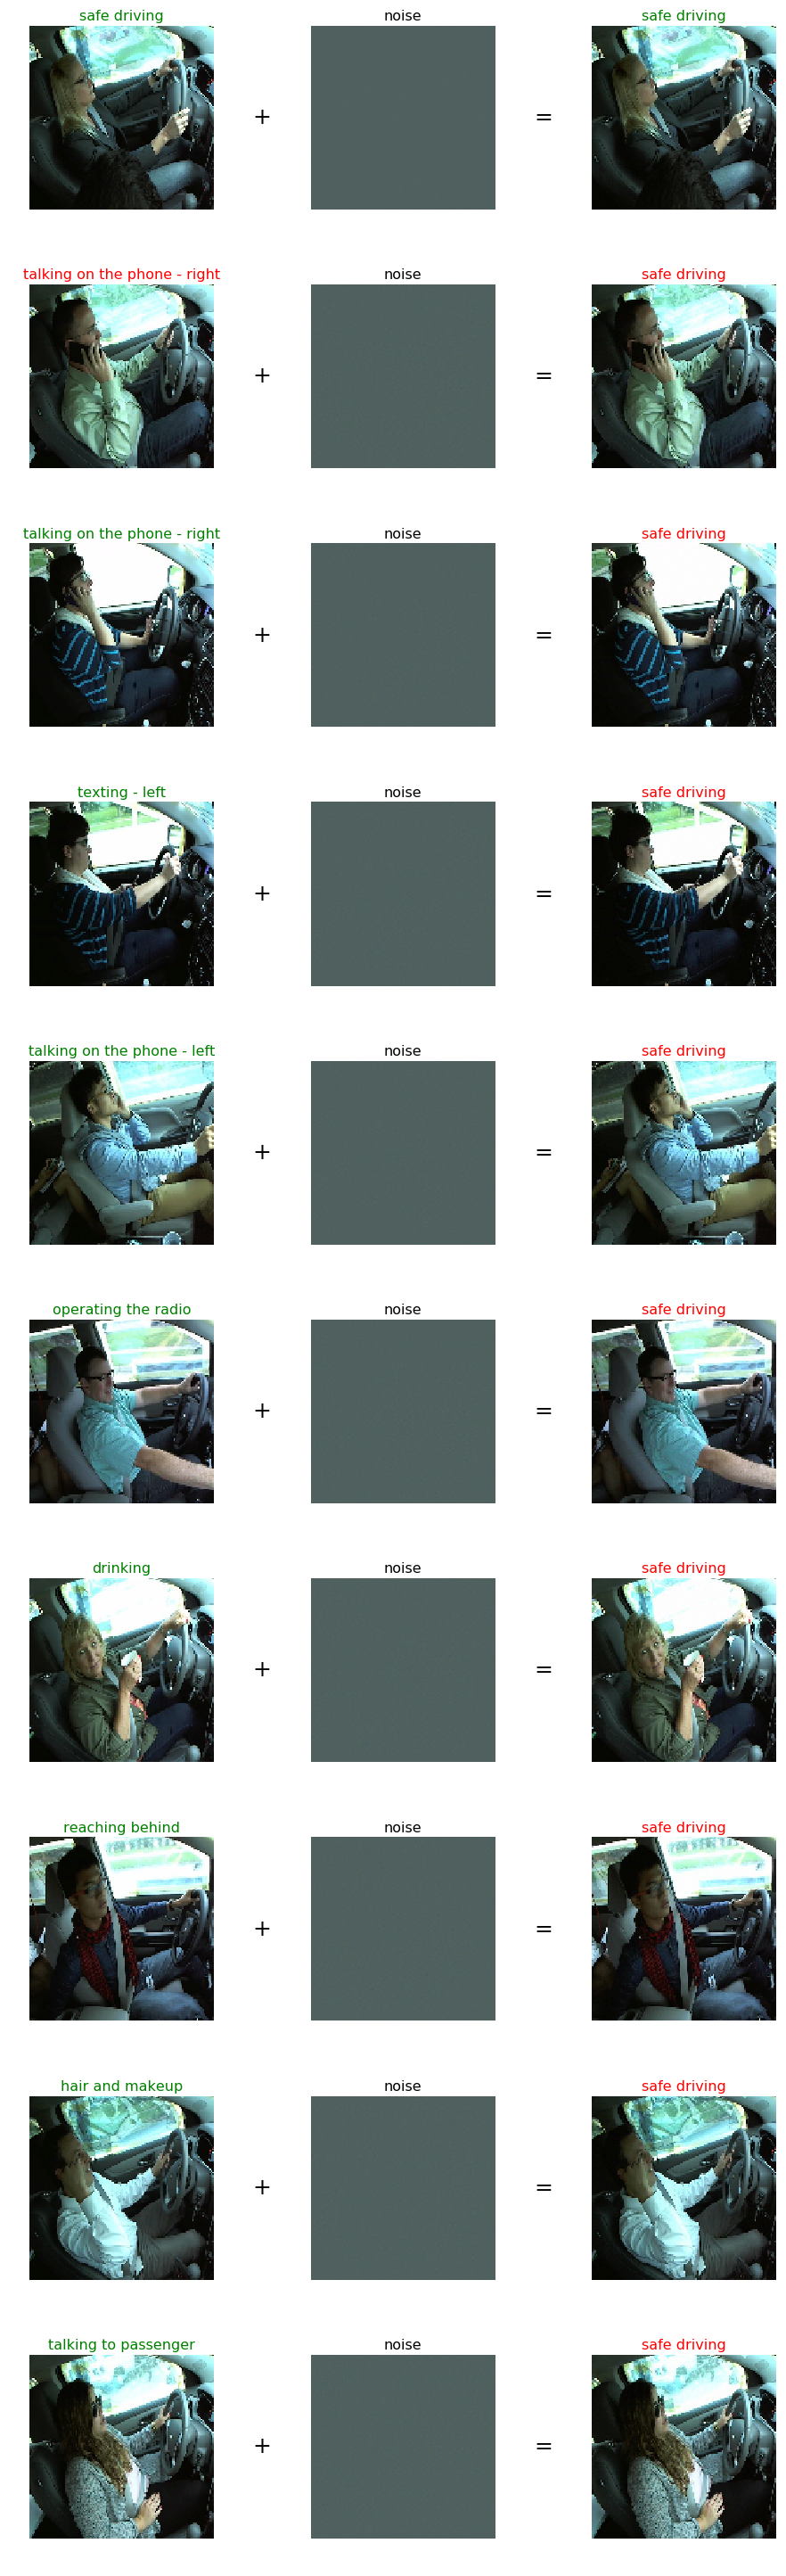

In [12]:
# plot the results
labels = np.argmax(model(imgs_tensor).data, axis=0)
labels_adversarial = np.argmax(model(imgs_tensor + eps).data, axis=0)
imgs = [DistractedDriver.denormalize(i).transpose((1, 2, 0)) for i in imgs]
imgs_noise = [DistractedDriver.denormalize(np.array(eps.data)[..., i]).transpose((1, 2, 0)).clip(0, 1) for i in range(len(imgs))]
imgs_adversarial = [DistractedDriver.denormalize(np.array((imgs_tensor + eps).data)[..., i]).transpose((1, 2, 0)).clip(0, 1) for i in range(len(imgs))]

gs = gridspec.GridSpec(10, 5, width_ratios=[1, .25, 1, .25, 1])
plt.figure(figsize=(15, 15*3.5)) 
for i in range(len(imgs)):
    plt.subplot(gs[i, 0])
    plt.axis('off')
    plt.title(DistractedDriver.label_names[labels[i]], color='g' if i == labels[i] else 'r', fontsize=16)
    plt.imshow(imgs[i])
    
    plt.subplot(gs[i, 1])
    plt.axis('off')
    plt.text(.5, .5, '+', horizontalalignment='center', verticalalignment='center', fontsize=25)
    
    plt.subplot(gs[i, 2])
    plt.axis('off')
    plt.title('noise', fontsize=16)
    plt.imshow(imgs_noise[i])
    
    plt.subplot(gs[i, 3])
    plt.axis('off')
    plt.text(.5, .5, '=', horizontalalignment='center', verticalalignment='center', fontsize=25)
    
    plt.subplot(gs[i, 4])
    plt.axis('off')
    plt.title(DistractedDriver.label_names[labels_adversarial[i]], color='g' if i == labels_adversarial[i] else 'r', fontsize=16)
    plt.imshow(imgs_adversarial[i])